In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [12]:
# Calculate the date 1 year ago from today

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

# Perform a query to retrieve the data and precipitation scores
last_12_month=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    filter(Measurement.date <= "2017-08-23").\
    order_by(Measurement.date).all()


print(last_12_month)


('2017-08-23',)
2016-08-23
[('2016-08-23', 0.0), ('2016-08-23', 0.15), ('2016-08-23', 0.05), ('2016-08-23', None), ('2016-08-23', 0.02), ('2016-08-23', 1.79), ('2016-08-23', 0.7), ('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ('2016-08-24', 1.22), ('2016-08-24', 2.15), ('2016-08-24', 1.45), ('2016-08-25', 0.08), ('2016-08-25', 0.08), ('2016-08-25', 0.0), ('2016-08-25', 0.0), ('2016-08-25', 0.21), ('2016-08-25', 0.06), ('2016-08-25', 0.11), ('2016-08-26', 0.0), ('2016-08-26', 0.03), ('2016-08-26', 0.02), ('2016-08-26', 0.04), ('2016-08-26', 0.0), ('2016-08-26', 0.01), ('2016-08-27', 0.0), ('2016-08-27', 0.18), ('2016-08-27', 0.02), ('2016-08-27', 0.0), ('2016-08-27', 0.12), ('2016-08-27', None), ('2016-08-28', 0.01), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.6), ('2016-08-28', 2.07), ('2016-08-29', 0.0), ('2016-08-29', 0.17), ('2016-08-29', 0.04), ('2016-08-29', None), ('2016-08-29', 0.0), ('2016-08-29', 

In [13]:

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_12_month)
# Sort the dataframe by date
prcp_df.sort_values(by=['date'])

prcp_df.set_index('date').head()

prcp
date            
2016-08-23  0.00
2016-08-23  0.15
2016-08-23  0.05
2016-08-23   NaN
2016-08-23  0.02

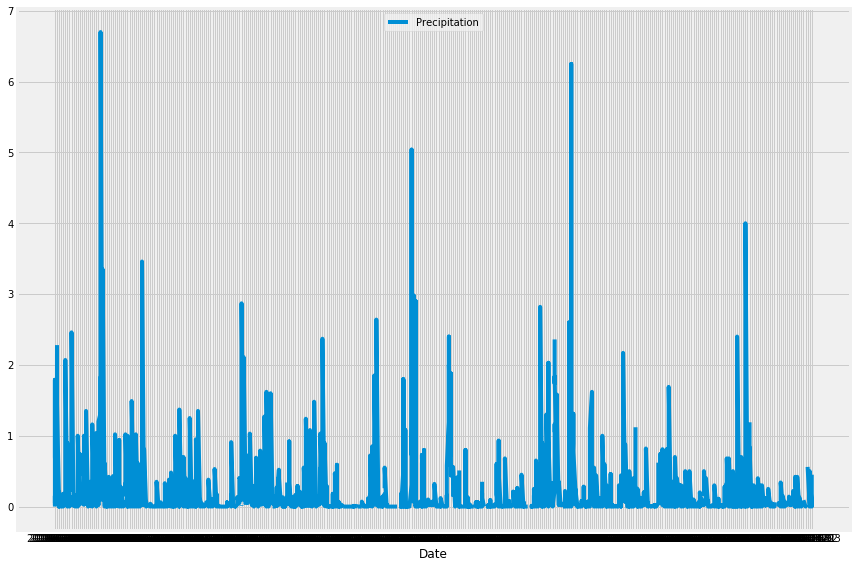

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(12,8))
plt.plot(prcp_df['date'], prcp_df['prcp'])
plt.xlabel("Date")
plt.legend(["Precipitation"], loc="upper center")
plt.tight_layout()
plt.grid(True)
plt.show()
plt.savefig('Images/Precipitation.png')

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

In [21]:
# How many stations are available in this dataset?
stations_count = session.query(Measurement).group_by(Measurement.station).count()
print(stations_count)

9


In [22]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = engine.execute('SELECT station, count(station) FROM Measurement GROUP BY station ORDER BY count(station) DESC').fetchall()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

station_temps = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()

station_temps

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [25]:
temp = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date >= last_year).\
                filter(Measurement.date <= "2017-08-23").all()

temp_df = pd.DataFrame(temp)
temp_df.set_index('station', inplace=True)
temp_df.head()

tobs
station          
USC00519281  77.0
USC00519281  77.0
USC00519281  80.0
USC00519281  80.0
USC00519281  75.0

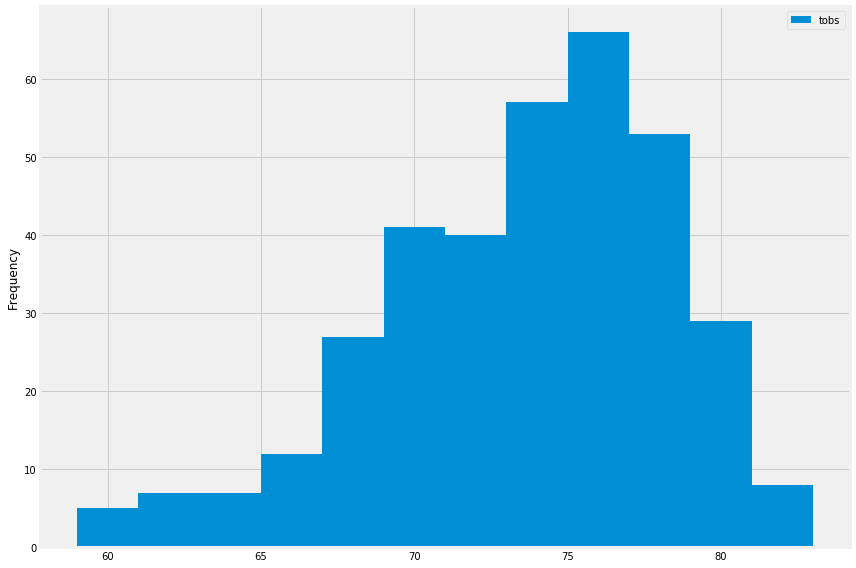

<Figure size 432x288 with 0 Axes>

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="upper right")
plt.tight_layout()
plt.grid(True)
plt.show()
plt.savefig('Images/Station.png')

In [28]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
  
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

    return calc_temps
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2012-02-28', '2012-03-05')
trip_results

[(62.0, 69.57142857142857, 74.0)]

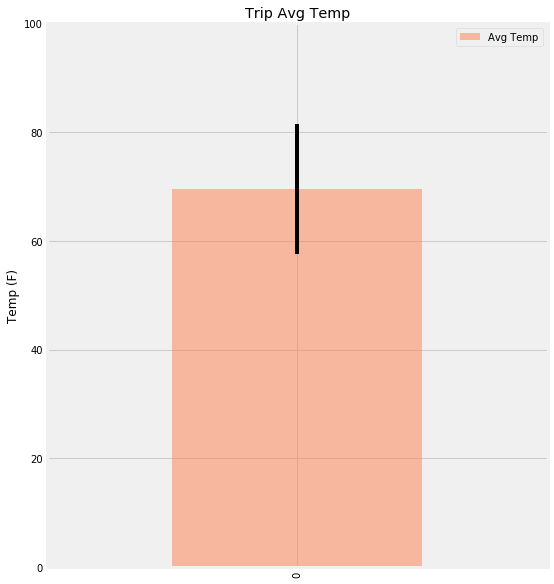

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot the results from your previous query as a bar chart. 
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')

# Use the average temperature for the y value
avg_temp = trip_df["Avg Temp"]

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_error = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']

avg_temp.plot(kind='bar', yerr=y_error, color='coral', alpha=.5, figsize=(8, 10))

plt.ylabel('Temp (F)')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
plt.yticks()
plt.show()
plt.savefig('Images/Trip_Ave_Temp.png')

In [31]:
trip_prcp = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
            filter (Station.station == Measurement.station).\
            filter(Measurement.date >= '2012-02-28').filter(Measurement.date <= '2012-03-05').\
            filter(Measurement.prcp != "none").\
            group_by(Station.station).\
            order_by(Measurement.prcp.desc()).all()
print(trip_prcp)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.05), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


<IPython.core.display.Javascript object>


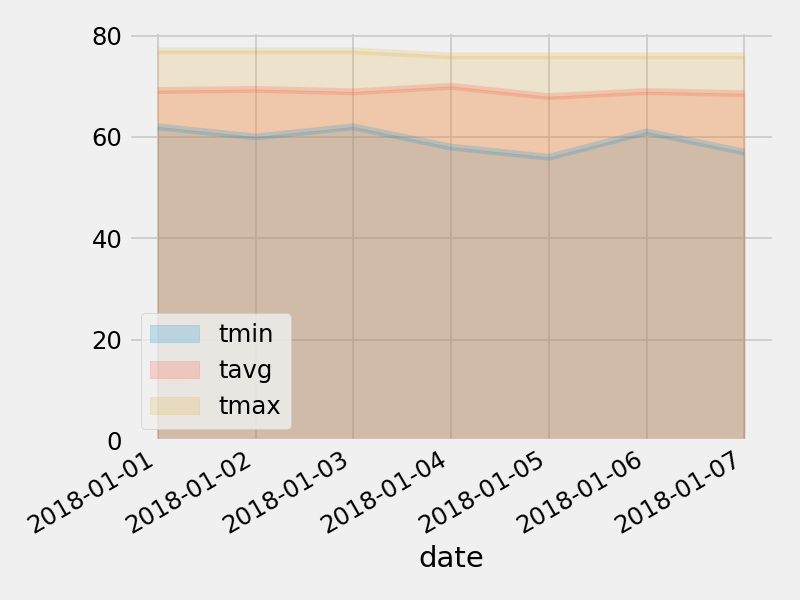

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
